# Block-Silhouette Analysis for CogSci 2020

## Import and set up directories

In [76]:
import os
import sys
import urllib, io
os.getcwd()
sys.path.append("..")
proj_dir = os.path.abspath('../..')

if os.path.join(proj_dir,'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'stimuli'))

import numpy as np
import scipy.stats as stats
import pandas as pd
from random import random

import pymongo as pm
from collections import Counter
import json
import re
import ast

from PIL import Image, ImageOps, ImageDraw, ImageFont 

from io import BytesIO
import base64

import  matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

import seaborn as sns
sns.set_context('talk')
sns.set_style('darkgrid')

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

import blockworld_helpers as utils
import drawing_utils as drawing
import importlib

In [77]:
## directory & file hierarchy
proj_dir = os.path.abspath('..')
datavol_dir = os.path.join(proj_dir,'data')
analysis_dir = os.path.abspath(os.path.join(os.getcwd(),'..'))
results_dir = os.path.join(proj_dir,'results')
plot_dir = os.path.join(results_dir,'plots')
csv_dir = os.path.join(results_dir,'csv')
json_dir = os.path.join(results_dir,'json')
exp_dir = os.path.abspath(os.path.join(proj_dir,'experiments'))
png_dir = os.path.abspath(os.path.join(datavol_dir,'png'))
jefan_dir = os.path.join(analysis_dir,'jefan')
will_dir = os.path.join(analysis_dir,'will')

## add helpers to python path
if os.path.join(proj_dir,'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'stimuli'))
    
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       

## Load Data

In [78]:
iteration_name = 'Exp2Pilot3'
num_trials = 24 #for sanity checks

In [79]:
# Data already compiled into dataframes in CogSci 2020 Dataframe Generator

# trial_end data
trial_path = os.path.join(csv_dir,'block_silhouette_{}.csv'.format(iteration_name))
df = pd.read_csv(trial_path)

# # initial_block data
initial_path = os.path.join(csv_dir,'block_silhouette_initial_{}.csv'.format(iteration_name))
dfi = pd.read_csv(initial_path)

# # settled_block data
settled_path = os.path.join(csv_dir,'block_silhouette_settled_{}.csv'.format(iteration_name))
dfs = pd.read_csv(settled_path)

# # Sanity Check- same participants in each dataset.
df_participants = df.gameID.unique()
dfs_participants = dfs.gameID.unique()
assert Counter(df_participants) == Counter(dfs_participants)

n_before_outliers = len(df_participants)
print(str(n_before_outliers) + ' participants total')

51 participants total


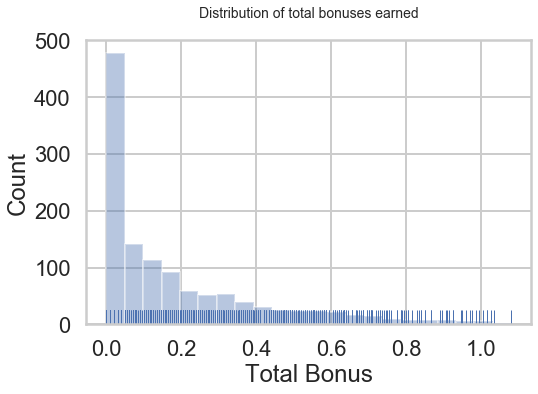

In [80]:
fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
c = sns.distplot(df['score'],
                rug=True,
                kde=False)
plt.ylabel('Count')
plt.xlabel('Total Bonus')
plt.title('Distribution of total bonuses earned\n',{'fontsize': 14})
plt.tight_layout()

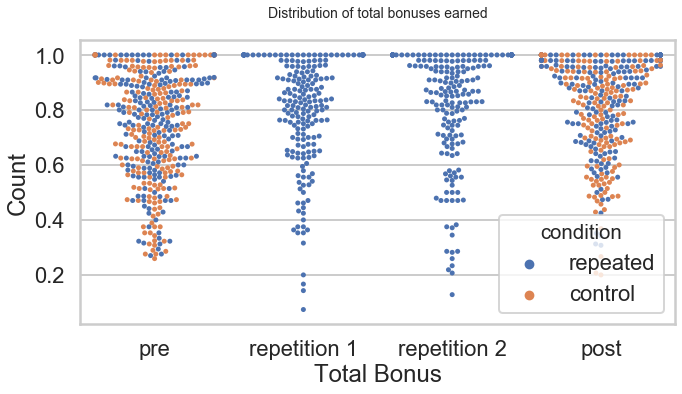

In [81]:
fig = plt.figure(figsize=(10,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
c = sns.swarmplot(x = 'phase_extended',
                  y = 'rawF1DiscreteScore',
                  hue = 'condition',
            data = df)
plt.ylabel('Count')
plt.xlabel('Total Bonus')
#plt.xticks(np.arange(df.gameID.nunique()),[str(n) for n in np.arange(df.gameID.nunique())])
plt.title('Distribution of total bonuses earned\n',{'fontsize': 14})
plt.tight_layout()


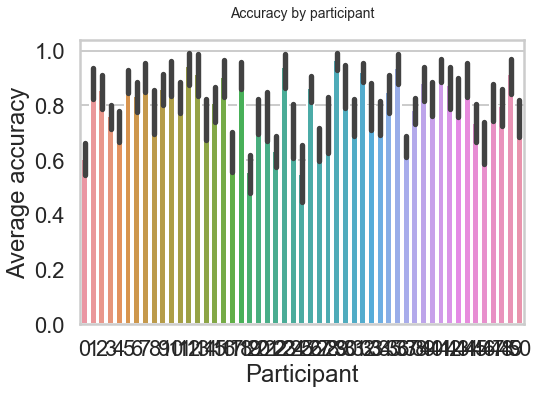

In [82]:
fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
c = sns.barplot(x = 'gameID',
                y = 'rawF1DiscreteScore',
                #hue = 'phase',
                #hue = 'repetition',
                data = df)
plt.ylabel('Average accuracy')
plt.xlabel('Participant')
plt.xticks(np.arange(df.gameID.nunique()),[str(n) for n in np.arange(df.gameID.nunique())])
plt.title('Accuracy by participant\n',{'fontsize': 14})
plt.tight_layout()

ValueError: cannot convert float NaN to integer

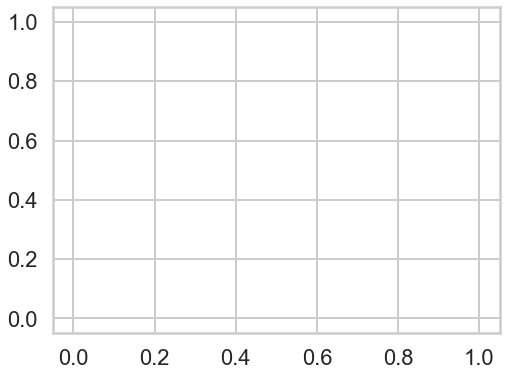

In [83]:
fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
c = sns.distplot(df['rawF1DiscreteScore'],
                rug=True,
                kde=False)
plt.ylabel('Count')
plt.xlabel('Accuracy')
plt.title('Distribution of Discrete F1 Scores\n',{'fontsize': 14})
plt.tight_layout()


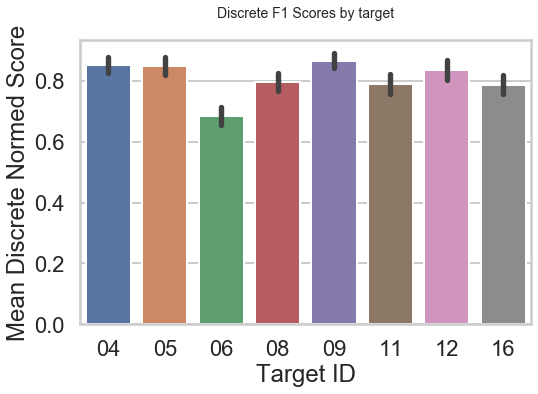

In [84]:
names = df.targetName.unique()
names.sort()
structure_numbers = list(map(lambda x: x[-2:],names))

fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
c = sns.barplot(x = 'targetName',
                y = 'rawF1DiscreteScore',
                order = names,
                data = df)
plt.ylabel('Mean Discrete Normed Score')
plt.xlabel('Target ID')
plt.xticks(np.arange(len(names)),structure_numbers)
plt.title('Discrete F1 Scores by target\n',{'fontsize': 14})
plt.tight_layout()

In [85]:
# exclude outliers with low mean normed score
remove_outliers = False

if remove_outliers:

    threshold = 0.7

    df_means = df.groupby(by=['gameID'])['normedScoreDiscrete'].apply(np.mean).reset_index()
    low_scores = df_means[df_means.normedScoreDiscrete< threshold]['gameID'] 
    print(low_scores)
    df = df[~df.gameID.isin(low_scores)]
    dfi = dfi[~dfi.gameID.isin(low_scores)]
    dfs = dfs[~dfs.gameID.isin(low_scores)]

    n = df.gameID.nunique()
    print(str(n) + ' participants with score <'+str(threshold)+' and full set of trials')



In [86]:
# Exclude outliers with low total bonus

remove_outliers = False

if remove_outliers:

    low_scores = df[(df.trialNum == (num_trials-1)) & (df.score == 0)]['gameID'] # people who achieved zero bonus


    df = df[~df.gameID.isin(low_scores)]
    dfi = dfi[~dfi.gameID.isin(low_scores)]
    dfs = dfs[~dfs.gameID.isin(low_scores)]

    n = df.gameID.nunique()
    print(str(n) + ' participants with score > 0 and full set of trials')


In [87]:
if False:
    importlib.reload(drawing)
    drawing.draw_all_trials(df, figsize=(20,80))

In [88]:
df[df.normedScoreDiscrete<0].iloc[[34]]

,Unnamed: 0,gameID,trialNum,phase,condition,eventType,targetName,repetition,targetID,nullScore,...,numRepetitions,bonusThresholdLow,bonusThresholdMid,bonusThresholdHigh,timeThresholdYellow,timeThresholdRed,rawF1DiscreteScore,jaccardDiscrete,phase_extended,phase_number
1132,1109,9659-5abde78c-ee50-4470-8814-d0f698fcd93b,4,pre,repeated,trial_end,hand_selected_011,0,5,0.158151,...,2,0.75,0.88,0.95,30000,15000,0.650794,0.482353,pre,0


In [89]:
df.loc[36]

Unnamed: 0                                                           829
gameID                         0443-fd078367-c19d-495d-84d5-3519a281435d
trialNum                                                              12
phase                                                           repeated
condition                                                       repeated
eventType                                                      trial_end
targetName                                             hand_selected_009
repetition                                                             2
targetID                                                               4
nullScore                                                       0.165589
F1Score                                                          0.99788
normedScore                                                     0.997459
rawScoreDiscrete                                                       1
nullScoreDiscrete                                  

In [90]:
importlib.reload(drawing)
drawing.draw_trials(df[df.normedScoreDiscrete<0], figsize=(20,80))

AttributeError: module 'drawing_utils' has no attribute 'draw_trials'

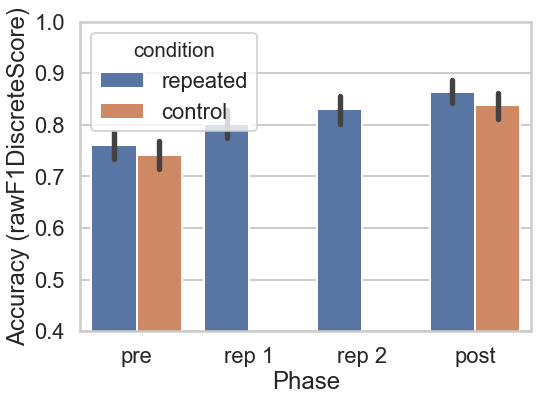

In [91]:
fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
c = sns.barplot(x='phase_extended', 
                y='rawF1DiscreteScore', 
                hue='condition', 
                #kind='point', 
                #legend=False,
                data=df);
plt.ylabel('Accuracy (rawF1DiscreteScore)')
plt.xlabel('Phase')
plt.ylim(0.4,1)
plt.xticks(np.arange(4),['pre','rep 1', 'rep 2', 'post'])
plt.tight_layout()


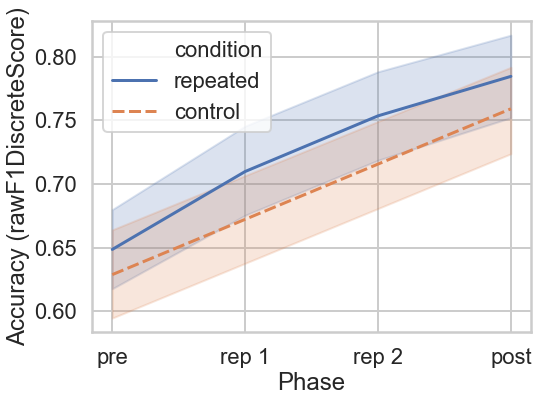

In [95]:
# Accuracy by phase
fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
c = sns.lineplot(x='phase_number', 
                y='rawF1DiscreteScore', 
                hue='condition',
                style='condition',
                style_order=['repeated','control'],
                #kind='point', 
                #legend=False,
                data=df);
plt.ylabel('Accuracy (rawF1DiscreteScore)')
plt.xlabel('Phase')
plt.xticks(np.arange(4),['pre','rep 1', 'rep 2', 'post'])
#plt.yticks(np.linspace(0.4,1,5))
plt.tight_layout()

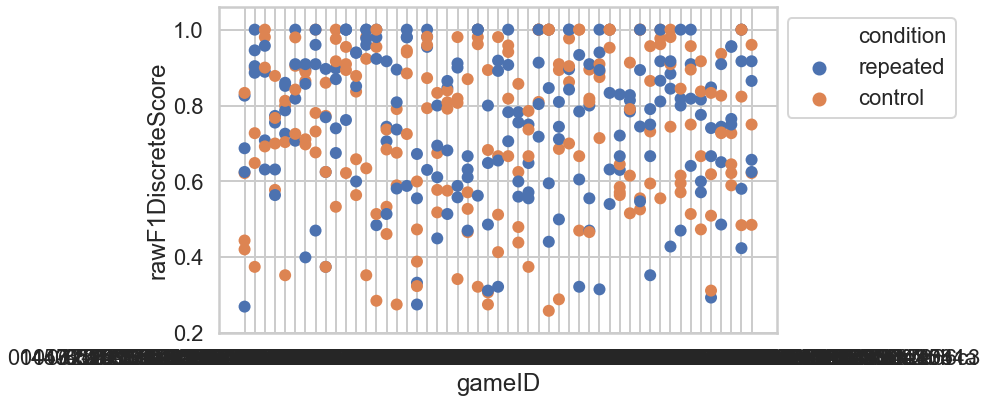

In [101]:
# Build Time over trials
fig = plt.figure(figsize=(10,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
#sns.set(style="ticks", rc={"lines.linewidth": 0.7})
c = sns.scatterplot(x='gameID', 
                    y='rawF1DiscreteScore', 
                    hue='condition',
                    #size= 'numBlocks',
                    #sizes=(16,16),
                    linewidth=0,
                    #palette="ch:r=-.3,d=.1_r",
                    #kind='point', 
                    data=df[df.phase=='pre'])
plt.legend(bbox_to_anchor=(1.0,1))
#plt.yticks(np.linspace(0.4,1,5))
#c.get_legend().set_visible(False)


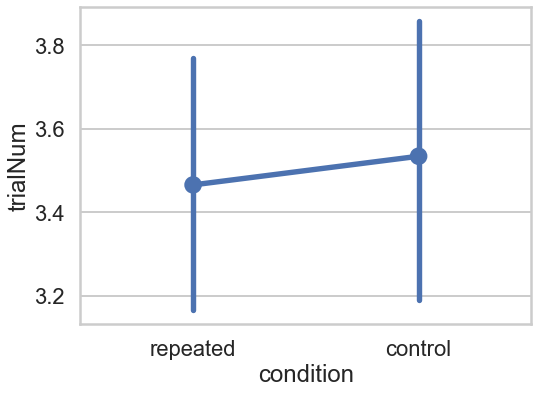

In [96]:
#double check that repeated condition isn't coming after control

fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
c = sns.pointplot(x='condition', 
                y='trialNum', 
                #hue='condition',
                #kind='point', 
                #legend=False,
                data=df[df.phase=='pre']);

#plt.yticks(np.linspace(0.4,1,5))
plt.tight_layout()

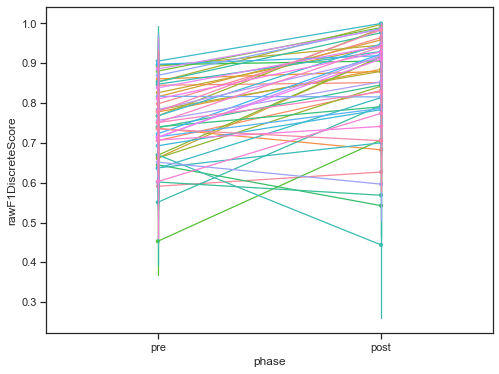

In [94]:
# Individual accuracy, pre- vs. post-

fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
c = sns.pointplot(x='phase', 
                  y='rawF1DiscreteScore', 
                  hue='gameID',
                  legend=False,
                  #kind='point', 
                  size = 0.3,
                  data=df[df.phase.isin(['pre','post'])])
#plt.yticks(np.linspace(0.4,1,5))
c.get_legend().set_visible(False)


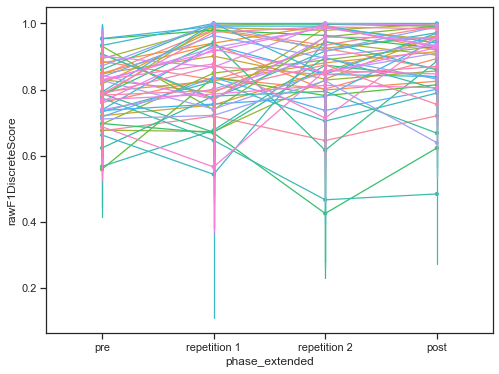

In [66]:
# Individual accuracy, all phases

fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
c = sns.pointplot(x='phase_extended', 
                  y='rawF1DiscreteScore', 
                  hue='gameID',
                  legend=False,
                  #kind='point', 
                  size = 0.3,
                  data=df)
#plt.yticks(np.linspace(0.4,1,5))
c.get_legend().set_visible(False)

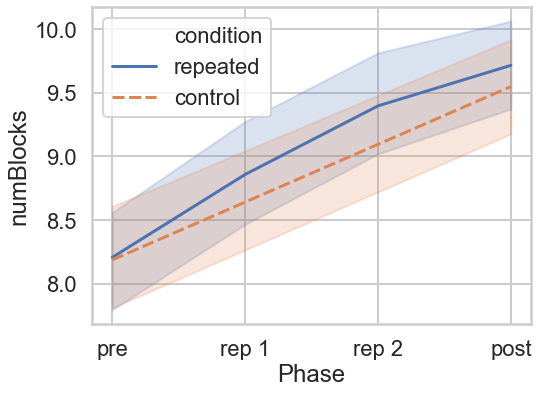

In [16]:
# Number of blocks placed by phase
# Should we control for fallen structures? 

df.groupby(by='phase_extended').apply(np.mean)


fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
c = sns.lineplot(x='phase_number', 
                y='numBlocks', 
                hue='condition',
                style='condition',
                style_order=['repeated','control'],
                #kind='point', 
                #legend=False,
                data=df);
plt.ylabel('numBlocks')
plt.xlabel('Phase')
plt.xticks(np.arange(4),['pre','rep 1', 'rep 2', 'post'])
#plt.yticks(np.linspace(0.4,1,5))
plt.tight_layout()

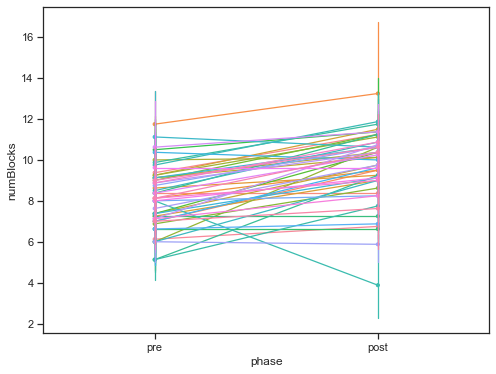

In [17]:
# Individual block use pre- and post- 

fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
c = sns.pointplot(x='phase', 
                  y='numBlocks', 
                  hue='gameID',
                  legend=False,
                  #kind='point', 
                  size = 0.3,
                  data=df[df.phase.isin(['pre','post'])])
#plt.yticks(np.linspace(0.4,1,5))
c.get_legend().set_visible(False)

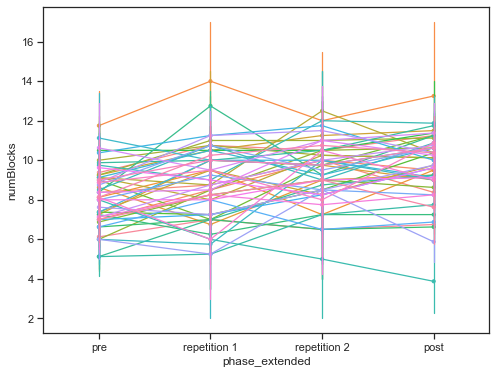

In [18]:
# Individual block use, all phases

fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
c = sns.pointplot(x='phase_extended', 
                  y='numBlocks', 
                  hue='gameID',
                  legend=False,
                  #kind='point', 
                  size = 0.3,
                  data=df)
#plt.yticks(np.linspace(0.4,1,5))
c.get_legend().set_visible(False)

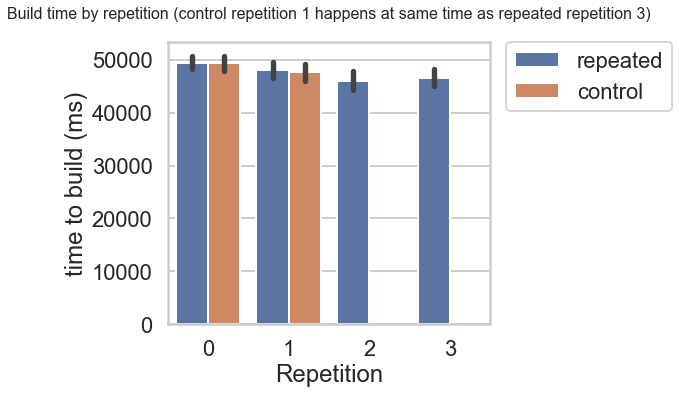

In [19]:
fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
c = sns.barplot(x='repetition', 
                y='timeToBuild', 
                hue='condition', 
                #kind='point', 
                #legend=False,
                data=df)
plt.ylabel('time to build (ms)')
plt.xlabel('Repetition')
plt.title('Build time by repetition (control repetition 1 happens at same time as repeated repetition 3)\n',{'fontsize': 16})
#plt.ylim(0.4,1)
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

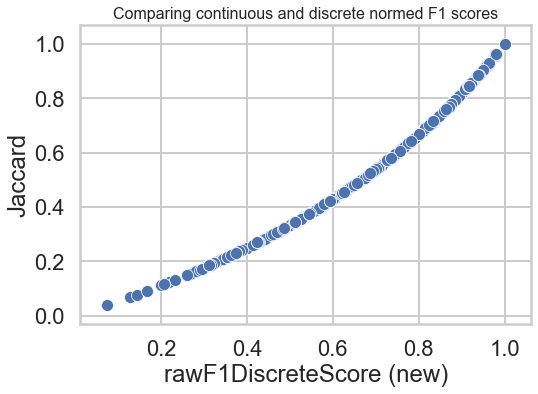

In [75]:
fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
c = sns.scatterplot(x='rawF1DiscreteScore', 
                y='jaccardDiscrete', 
                #hue='condition', 
                #kind='point', 
                #legend=False,
                data=df)
plt.ylabel('Jaccard')
plt.xlabel('rawF1DiscreteScore (new)')
plt.title('Comparing continuous and discrete normed F1 scores',{'fontsize': 16})
#plt.ylim(0.4,1)
plt.tight_layout()


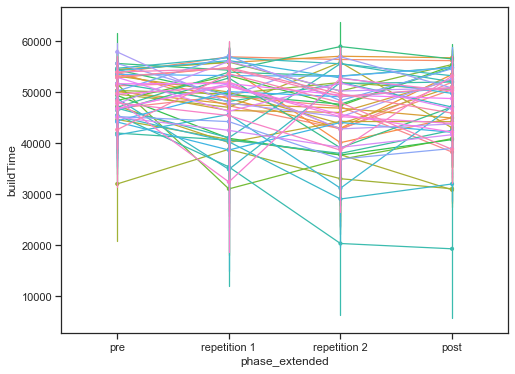

In [21]:
# Build Time over trials

fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
c = sns.pointplot(x='phase_extended', 
                  y='buildTime', 
                  hue='gameID',
                  legend=False,
                  #kind='point', 
                  size = 0.3,
                  data=df)
#plt.yticks(np.linspace(0.4,1,5))
c.get_legend().set_visible(False)

In [22]:
df['perfectScore'] = df.normedScoreDiscrete == 1

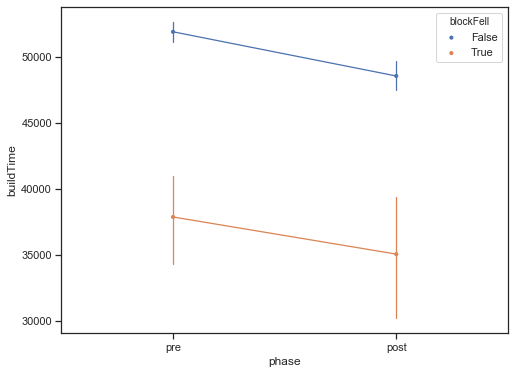

In [23]:
# Build Time over trials
fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
c = sns.pointplot(x='phase', 
                  y='buildTime', 
                  hue='blockFell',
                  legend=False,
                  #kind='point', 
                  size = 0.3,
                  data=df[df.phase.isin(['pre','post'])])
#plt.yticks(np.linspace(0.4,1,5))
#c.get_legend().set_visible(False)

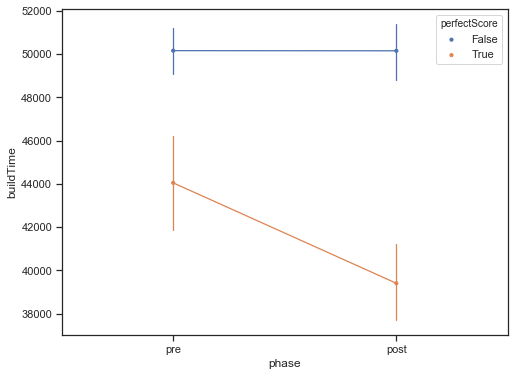

In [24]:
# Build Time over trials
fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
c = sns.pointplot(x='phase', 
                  y='buildTime', 
                  hue='perfectScore',
                  legend=False,
                  #kind='point', 
                  size = 0.3,
                  data=df[df.phase.isin(['pre','post'])])
#plt.yticks(np.linspace(0.4,1,5))
#c.get_legend().set_visible(False)

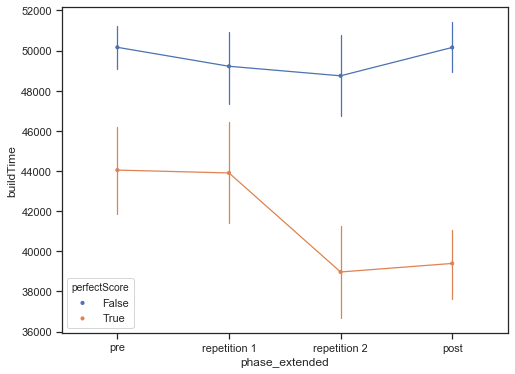

In [25]:
# Build Time over trials
fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
c = sns.pointplot(x='phase_extended', 
                  y='buildTime', 
                  hue='perfectScore',
                  legend=False,
                  #kind='point', 
                  size = 0.3,
                  data=df)
#plt.yticks(np.linspace(0.4,1,5))
#c.get_legend().set_visible(False)


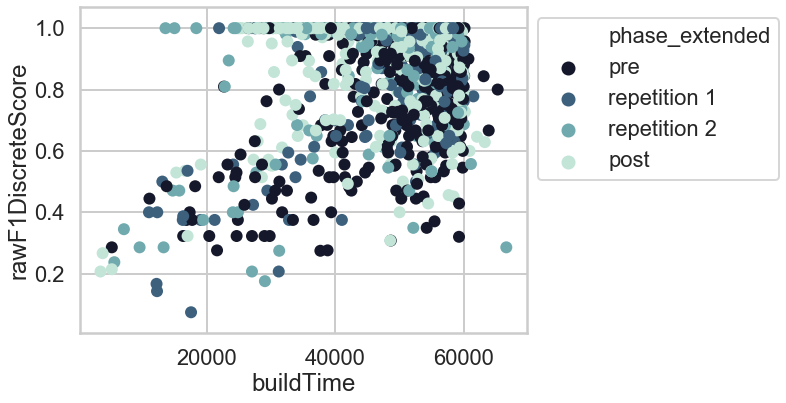

In [67]:
# Build Time over trials
fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
#sns.set(style="ticks", rc={"lines.linewidth": 0.7})
c = sns.scatterplot(x='buildTime', 
                    y='rawF1DiscreteScore', 
                    hue='phase_extended',
                    #size= 'numBlocks',
                    #sizes=(16,16),
                    linewidth=0,
                    palette="ch:r=-.3,d=.1_r",
                    #kind='point', 
                    data=df)
plt.legend(bbox_to_anchor=(1.0,1))
#plt.yticks(np.linspace(0.4,1,5))
#c.get_legend().set_visible(False)


In [27]:
df['ta-bst'] = df['timeAbsolute']-df['buildStartTime']
df['normedScoreDiscrete'] = df['rawScoreDiscrete'] 
df[['buildTime','blockFell','ta-bst','normedScore','normedScoreDiscrete']]

,buildTime,blockFell,ta-bst,normedScore,normedScoreDiscrete
0,56535,False,60102.0,0.787627,0.627660
1,31300,False,60082.0,0.402863,0.017857
2,55969,False,60076.0,0.605865,0.248042
3,57866,False,60104.0,0.622119,0.225806
4,57225,False,60087.0,0.415032,-0.024531
5,53172,False,60080.0,0.823713,0.655914
6,55423,False,60097.0,0.269396,-0.320720
7,42845,False,60108.0,0.557838,0.354839
8,57833,False,60089.0,0.686293,0.296703
9,53543,False,60080.0,0.599597,0.091530
